In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pydicom
from pydicom.data import get_testdata_file
import plotly.graph_objects as go

from skimage import data
from skimage.transform import radon,iradon,resize
from skimage.util import random_noise

Matplotlib is building the font cache; this may take a moment.


In [2]:
def mu_func(x,y):
    global A_func
    global a_func
    global x0_func
    global y0_func
    global func_name

    if func_name == 0:
        r2 = (x- x0_func)**2+(y-y0_func)**2
        return A_func*r2*np.exp(-r2/a_func**2)

    if func_name == 2:
        return A_func*np.exp(-((x-x0_func)**2 + (y-y0_func)**2)/a_func**2)

    if func_name == 3:
        ro = np.sqrt((x - x0_func)**2 + (y - y0_func)**2)
        if a_func - ro >=0.:
            return A_func
        else:
            return 0.

def mu_func_array():
    global N_xy
    mu = np.zeros((N_xy,N_xy))
    for int_x in range(N_xy):
        for int_y in range(N_xy):
            mu[int_x, int_y] = mu_func(int_to_xy(int_x),int_to_xy(int_y))

    return mu

def p_func(ksi, theta):
    global A_func
    global a_func
    global x0_func
    global y0_func
    global func_name
    ksi_ = ksi - x0_func*np.cos(theta) - y0_func*np.sin(theta)
    if func_name == 0:
        if ksi_ == 0:
            return 0.8862269254527578
        return np.sqrt(np.pi)*A_func*a_func*ksi_**2*np.exp(-ksi_**2/a_func**2)*(a_func**2/2/ksi_**2+1)
    if func_name == 2:
        return np.sqrt(np.pi)*A_func*a_func*np.exp(-ksi_**2/a_func**2)

    if func_name == 3:
        if a_func >= np.abs(ksi_):
            return 2*A_func*np.abs(ksi_)*np.sqrt((a_func/ksi_)**2-1)
        else:
            return 0.



def p_func_array():
    global N_angels
    global N_rays
    p = np.zeros((N_rays,N_angels))
    for int_theta in range(N_angels):
        for int_ksi in range(N_rays):
            p[int_ksi, int_theta] = p_func(int_to_ksi(int_ksi),int_to_theta(int_theta))

    return p

In [3]:
def theta_to_int(theta):
    global N_angels
    return int(theta/2/np.pi*N_angels)

def ksi_to_int(ksi):
    global xy_max
    global rays_d
    return int((ksi + np.sqrt(2)*xy_max)/rays_d)

def xy_to_int(xy):
    global N_xy
    global xy_max
    return int((xy + xy_max)/2/xy_max*N_xy)

def int_to_theta(i):
    global N_angels
    return i*2.*np.pi/N_angels

def int_to_ksi(i):
    global xy_max
    global rays_d
    return i*rays_d - np.sqrt(2)*xy_max

def int_to_xy(i):
    global N_xy
    global xy_max
    return 2*xy_max/N_xy*i - xy_max

def dicom_to_Hounsfield_to_mu(dicom_file):
    mu_air = 1.38*1e-4
    mu_water = 0.12
    if 'RescaleSlope' in dicom_file and 'RescaleIntercept' in dicom_file:
        slope = dicom_file.RescaleSlope
        intercept = dicom_file.RescaleIntercept
    array = dicom_file.pixel_array*slope + intercept
    return array/1000*(mu_water - mu_air) + mu_water

In [108]:
def ray_tracing(theta, x, y):
    global N_xy
    q = np.zeros(3)           # используется только внутри цикла, не трогать
    qmin = np.zeros(3) - 1.  # наименьшие координаты в сетке
    qmax = np.zeros(3) + N_xy + 1 # наибольшие координаты в сетке
    dq = np.ones(3)           # шаг сетки
    # dq2 = np.power(dq, 2)
    rho = np.zeros(3)
    # nq = ((qmax - qmin) / dq).astype(np.int32)

    # tid = 0

    q0 = np.array([xy_to_int(x), xy_to_int(y), 0.]) # координата начала луча
    pq = np.array([-np.sin(theta), np.cos(theta), 0]) # направление движения луча
    pq = pq + 1e-9
    pq = pq / np.sqrt((pq**2).sum())
    # ekin = 1

    # initial conditions
    q = q0
    b = (np.sign(pq) + 1)
    points = []
    ppqq = pq*1e-3
    while (qmin < q).all() and (q < qmax).all():
        qq = q + 1e-9*np.sign(q)
        iq = ((qq - qmin) / dq).astype(np.int32)
        a = iq*dq - (qq-qmin)
        rho = a + b*dq/2 + (1 - np.sign(a)**2)
        dt = np.abs(rho / pq).min()
        points.append(q.copy())
        q += (pq+ppqq)*dt
    _ = pd.DataFrame(points, columns=['x','y', 'z'])
    return np.array([_['x'].values, _['y'].values])






def ray_origin_coordinates(theta, ksi):
    global xy_max
    # по сути нам нужно найти пересечение линии ksi = x*cos(theta) + y*sin(theta) и границы снимка,
    # чтобы начать отслеживать луч именно от нее и избежать лишних вычислений
    # if -1.e-10 < np.sin(theta) < 1.e-10 or -1.e-10 < np.cos(theta) < 1.e-10 == 0:
    #     return np.nan, np.nan

    x_line = xy_max*np.sign(np.sin(theta))
    y_line = -xy_max*np.sign(np.cos(theta))
    if not x_line: x_line = -xy_max

    y = y_line
    x = (ksi-y*np.sin(theta))/np.cos(theta)
    if -xy_max <= x <= xy_max:
        return x, y
    
    x = x_line
    y = (ksi-x*np.cos(theta))/np.sin(theta)
    if -xy_max <= y <= xy_max:
        return x, y
    return np.nan, np.nan



def ray_projection(points, mu):
    if len(points[0,:])>1:
        integral_1_7 = 0
        for i in range(1, len(points[0,:]) - 1):
            q_1 = points[:,i]
            q_2 = points[:,i+1]
            d_dzeta = np.sqrt(((q_2-q_1)**2).sum())
            x_coordinates = np.array([q_1[0], q_2[0]])
            y_coordinates = np.array([q_1[1], q_2[1]])
            x = (x_coordinates.min()).astype(np.int32)
            y = (y_coordinates.min()).astype(np.int32)
            if x < N_xy and y < N_xy:################ это костыль для работы рей трейсинга
                if mu[x,y]> mu_max:
                    return 2*1e+10
                integral_1_7+= mu[x,y]*d_dzeta
        return integral_1_7
    return 0.


def CT_simulation(mu):
    global N_xy
    global N_rays
    global N_angels
    p = np.zeros((N_rays,N_angels))
    for int_theta in range(N_angels):
        for int_ksi in range(N_rays):
            x, y = ray_origin_coordinates(int_to_theta(int_theta), int_to_ksi(int_ksi))
            if x != x or y != y:
                pass
            else:
                net_points = ray_tracing(int_to_theta(int_theta), x, y)
                p[int_ksi,int_theta] = ray_projection(net_points, mu)
    return p

In [18]:
def sinc(x):
    if x == 0:
        return 1
    return np.sin(x)/x

def h1(ksi):
    # xi0 = 0.1
    global xi0
    return xi0**2/np.pi/2*(sinc(xi0*ksi) - (sinc(xi0*ksi/2))**2/2.)


def p_convolution(p:np.array): #функция, возвращающая одномерную свертку двумерной функции
    global N_rays
    global N_angels
    global rays_d # dksi при численном интегрировании
    f = np.zeros((N_rays,N_angels))
    for int_ksi in range(N_rays):
        for int_theta in range(N_angels):
            integral_1_47 = 0
            for int_ksi0 in range(N_rays):
                ksi_minus_ksi0 = int_to_ksi(int_ksi-int_ksi0)
                integral_1_47+=p[int_ksi0,int_theta]*h1(ksi_minus_ksi0)
            f[int_ksi,int_theta] = integral_1_47*rays_d

    return f

def mu_restored(f:np.array):
    global N_xy
    global N_angels
    mu_evalv = np.zeros((N_xy,N_xy))
    for int_x in range(N_xy):
        for int_y in range(N_xy):
            integral_1_49 = 0
            for int_theta in range(N_angels):
                x = int_to_xy(int_x)
                y = int_to_xy(int_y)
                theta = int_to_theta(int_theta)
                ksi = x*np.cos(theta) + y*np.sin(theta)
                integral_1_49+=f[ksi_to_int(ksi),int_theta]
            mu_evalv[int_x, int_y] = integral_1_49/N_angels # вообще должно быть *dtheta/2/np.pi, но dtheta = 2*np.pi/N_angels

    return mu_evalv

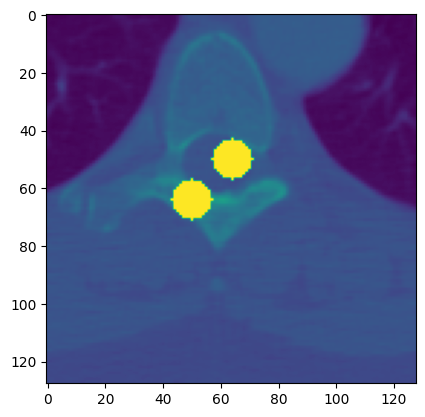

In [109]:
filename = get_testdata_file("CT_small.dcm")
dsct = pydicom.dcmread(filename)
mu = dicom_to_Hounsfield_to_mu(dsct)

mu_max = 0.5

a = 7
i0 = 64
j0 = 50
for i in range(N_xy):
    for j in range(N_xy):
        if (i-i0)**2 + (j-j0)**2 <= a**2 or (i-j0)**2 + (j-i0)**2 <= a**2:
            mu[i, j] = mu_max*0.9

N_angels = 128 # количество углов вращения
N_rays = 182 # количество лучей в пучке (картинку будет задевать как правило только часть лучей)
N_xy = dsct.pixel_array.shape[0] # размер сетки в единицах имерения количества штук клеток. По сути - развер картинки в пикселях, например, если картинка 512х512, то N_xy=512
xy_max = 100 # размер половины сетки в сантиметрах. Стоит учесть, что в сантиметрах система координат в центре, а в пиксилях - в углу
rays_d = np.sqrt(2)*2*xy_max/N_rays # расстояние между лучами

# func_name = 0
# A_func = 1
# a_func = 30
# x0_func = 35
# y0_func = 35
# # p = p_func_array()
# mu = mu_func_array()

plt.imshow(mu)
plt.show()

In [42]:
dsct

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 192
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.5962.1.1.1.1.1.20040119072730.12322
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.5962.2
(0002, 0013) Implementation Version Name         SH: 'DCTOOL100'
(0002, 0016) Source Application Entity Title     AE: 'CLUNIE1'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0012) Instance Creation Date              DA: '20040119'
(0008, 0013) Instance Creation Time              TM: '072731'
(0008, 0014) Instance Creator UID                U

C:\Temp\ipykernel_6768\812116470.py:57: RuntimeWarning:

divide by zero encountered in scalar divide



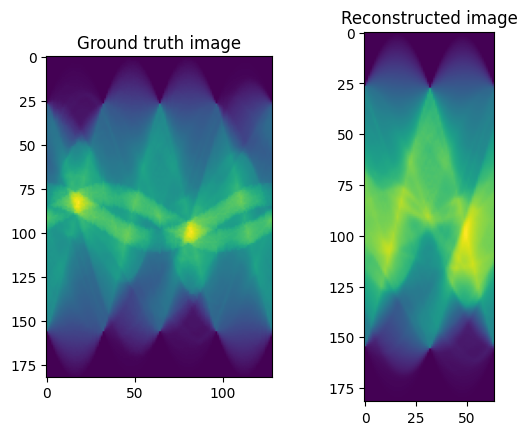

In [110]:

p = CT_simulation(mu)

# xi0 = 0.1
# f = p_convolution(p)
# mu_eval = mu_restored(f)

fig, ax = plt.subplots(1,2)

ax[0].imshow(p)
ax[0].set_title('Ground truth image')

ax[1].imshow(sinogram)
ax[1].set_title('Reconstructed image')

plt.show()

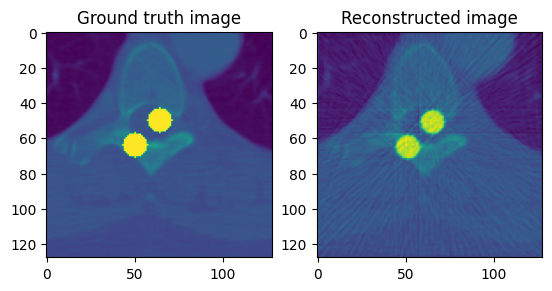

In [112]:
n = 64
theta = np.linspace(0., 180.,n, endpoint=False)
sigma = 1e-1
image_reconstructed = iradon(p[:,32:96], theta=theta, circle = False)

# plot
fig, ax = plt.subplots(1,2)

ax[0].imshow(mu)
ax[0].set_title('Ground truth image')

ax[1].imshow(image_reconstructed)
ax[1].set_title('Reconstructed image')

plt.show()

In [77]:
sinogram = radon(mu, theta=theta, circle = False)
xi0 = 0.1
f = p_convolution(sinogram)
mu_eval = mu_restored(f)

IndexError: index 64 is out of bounds for axis 1 with size 64

In [56]:
mu_3d = go.Surface(z=mu, x=np.asarray(range(N_xy)), y=np.asarray(range(N_xy)))
fig = go.Figure(data = [mu_3d])
fig.show()

In [34]:
mu_3d = go.Surface(z=mu_eval, x=np.asarray(range(N_xy)), y=np.asarray(range(N_xy)))
fig = go.Figure(data = [mu_3d])
fig.show()